In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

/root/miniconda3/lib/python3.12/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [ ]:
from rdkit import Chem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

number of all smiles:  1427


[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not removing hydrogen atom without neighbors
[05:26:00] WARNING: not r

number of successfully processed smiles:  1427


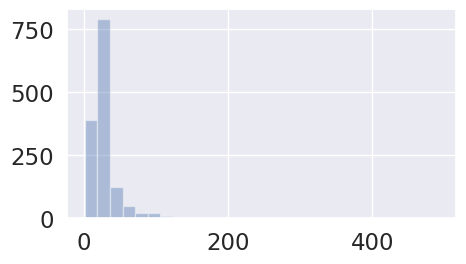

In [ ]:
task_name = 'sider'
tasks = [
'SIDER1','SIDER2','SIDER3','SIDER4','SIDER5','SIDER6','SIDER7','SIDER8','SIDER9','SIDER10','SIDER11','SIDER12','SIDER13','SIDER14','SIDER15','SIDER16','SIDER17','SIDER18','SIDER19','SIDER20','SIDER21','SIDER22','SIDER23','SIDER24','SIDER25','SIDER26','SIDER27'
]
raw_filename = "../data/sider.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()

In [5]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.5
fingerprint_dim = 200

radius = 3
T = 3
weight_decay = 3 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [ ]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors
[05:26:01] WARNING: not removing hydrogen atom without neighbors


,SIDER1,SIDER2,SIDER3,SIDER4,SIDER5,SIDER6,SIDER7,SIDER8,SIDER9,SIDER10,...,SIDER20,SIDER21,SIDER22,SIDER23,SIDER24,SIDER25,SIDER26,SIDER27,smiles,cano_smiles
5,0,1,0,1,1,1,1,0,1,0,...,1,1,1,0,0,1,1,1,CC[C@H](C)[C@H]1C(=O)N[C@H]2CSSC[C@@H](C(=O)N[...,CC[C@H](C)[C@H](NC(=O)CN)C(=O)N[C@H](C(=O)N[C@...
29,1,1,0,1,1,1,1,1,1,0,...,1,1,1,0,1,1,1,1,CC[C@H](C)[C@@H](C(=O)N[C@@H](CCC(=O)O)C(=O)N[...,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H]...
41,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,N,N
47,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,1,1,CC[C@H](C)[C@@H](C(=O)N[C@@H](CC1=CC=C(C=C1)O)...,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...
50,0,0,0,1,1,1,1,0,1,1,...,1,1,0,0,0,1,1,1,I,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,1,0,0,0,1,1,1,0,1,0,...,0,1,1,0,0,1,1,0,CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)COP(=...,COCCO[C@@H]1[C@H](SP(=O)([O-])OC[C@H]2O[C@@H](...
1392,0,1,0,0,1,1,1,0,1,0,...,1,1,1,0,1,1,1,1,CCC(C)C(C(=O)NC(CCC(=O)N)C(=O)NC(CC(C)C)C(=O)N...,CCC(C)C(NC(=O)C(CCC(=O)O)NC(=O)C(CO)NC(=O)C(NC...
1393,0,1,0,1,1,1,1,1,1,0,...,1,1,1,0,1,1,1,1,CC1C(=O)NC(C(=O)NC2CSSCC3C(=O)NC(C(=O)NC(C(=O)...,CSCCC1NC(=O)C(CC(C)C)NC(=O)C(CCCNC(=N)N)NC(=O)...
1396,0,1,0,0,1,1,1,0,1,0,...,1,1,1,0,0,0,1,1,CC[C@H](C)[C@H]1C(=O)N[C@H](C(=O)NCC(=O)N[C@H]...,CC[C@H](C)[C@@H]1NC(=O)[C@@H]2CSSC[C@H](NC(=O)...


In [7]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=3) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=3) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [8]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1156058
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [ ]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))

            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]

    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss 


In [ ]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.62:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
        break
        
    train(model, train_df, optimizer, loss_function)


/tmp/ipykernel_65897/1100950197.py:55: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))


EPOCH:	0
train_roc_mean:0.5013257983300141
valid_roc_mean:0.5034681350123162

EPOCH:	1
train_roc_mean:0.5543366787595173
valid_roc_mean:0.5328603303217478

EPOCH:	2
train_roc_mean:0.5642245769133652
valid_roc_mean:0.5261042760974386

EPOCH:	3
train_roc_mean:0.576267537922496
valid_roc_mean:0.5357537691230827

EPOCH:	4
train_roc_mean:0.583845757122824
valid_roc_mean:0.5355388331808116

EPOCH:	5
train_roc_mean:0.5880795334700147
valid_roc_mean:0.5482308162409555

EPOCH:	6
train_roc_mean:0.589011591824554
valid_roc_mean:0.5579235834948016

EPOCH:	7
train_roc_mean:0.5940559516073137
valid_roc_mean:0.5597053583753607

EPOCH:	8
train_roc_mean:0.5940525132687974
valid_roc_mean:0.5646171256503449

EPOCH:	9
train_roc_mean:0.5962548102300639
valid_roc_mean:0.5663339912779034

EPOCH:	10
train_roc_mean:0.5993740586082568
valid_roc_mean:0.5572249437588925

EPOCH:	11
train_roc_mean:0.602381546078106
valid_roc_mean:0.5624493212163183

EPOCH:	12
train_roc_mean:0.607436140787396
valid_roc_mean:0.547115

In [ ]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )